# NYC Ferry Data Ridership Data Time Series Forecasts

Using time series methods we  predicted Ferry system boarding numbers and revenue for the next year. Note: I have no affiliation with the NYC Ferry.

<img src="BoardingsNumberAndPredictions.png" width="700" align="left"/>



The current data only goes up to October 2023.

We can look at the predictions from our model for the dates from november 2023 to October 2024:

<img src="BoardingsPredictions_11-23to10-24.png" width="240" align="left"/>


# NYC Ferry Ridership Data Analysis

Suppose we are working for the firm that runs the NYC Ferry system. One of our goals may be to understand the number of riders who use the system. In order to do this, we can look at the nyc ferry ridership dataset.

We can think of the NYC Ferry system as a collection of routes R, where for for each route $r \in R$, we can have $r(t)$ defined as the number of boardings at time t, where t lies in our chosen collection of time granules, i.e. t lies in a set of days, months years, etc. The actual data gives us granualarity up to the hour

### Background

The NYC Ferry System is a collection of ferries that serve nyc. The ferry system is made up of different routes. Each ferry moves along a route, and each route has multiple stops. At each stop, people can board and exit their ferry boat. 

The NYC Ferry System consists of a collection of routes, where where passengers board and exit ferry boats each hour along each route.

### The Data

Our dataset is collection of rows where each row represents the number of bordings at a stop along a specific route at a specific hour on a specific day. Each row row also contains the time up to the hour for when the boardings happened.


The data comes in a csv format, with 2,031,036 rows, and 7 columns. 

The data is from the following URL:
https://data.cityofnewyork.us/Transportation/NYC-Ferry-Ridership/t5n6-gx8c

<img src="TotalBoardingsGraph.png" width="700" align="left"/>


### Our goal

Our goal is to understand the riderships numbers of the nyc ferry system.

### What We'll Do and Our Tools

For this anlysis, we will use python, and more specifically, pandas to load and organize the data, numpy to perform computations on the data, and matplotlib to visualize the data.

### Our Model

We will assume the model of $X_t = T_tS_tI_t$, where $T_t$ is a determinstic trend component, $S_t$ is a deterministic seasonal component, and $I_t$ is a random variable with $E(I_t) = 1$ and $Var(I_t) = \sigma^2$ fot all $t$.

We will assume $T_t = \beta_1 t + \beta_0$ and that $E(S_tI_t) = S_tE(I_t) = S_t1 = S_t$ for all $t$. Note: at any $t$, $S_t$ being determinstic implies $E(S_t) = S_t$. We will assume $S_t$ is periodic over a one year period.

To estimate the trend component, we will do a 12 month moving average of our data $x(t)$, so that we can average out 
the within year fluctuations due to seasonality and the irregular component, and then we will divide our data by 
the MA12 to estimate $S_tI_t$, and then we will average our estimate of $S_tI_t$ at each quarter to get our estimate
$\hat{S}_t$. Then we will do $x(t)/\hat{S}_t$ to achieve deseasonalized data. Even though the multiplicative model assumes heteroskedacity of the errors for the $T_tI_t$ component, we still have $E(T_tI_t) = T_t$, and the OLS $\hat{\beta}_1$ estimator is unbiased even with heteroskedacity.

After finding $\hat{\beta}_0 \text{ and } \hat{\beta}_1$, we can bring together our estimates to create our model:
$\hat{X}_t = \hat{T}_t\hat{S}_t$


When we look at the data, we see a big jump around 2020, so we will only use the data after 2020 to compute the trend. To get more data for the seasonality component, we will use the detrended data from before and after 2020 to compute $\hat{S}_t$.

### Pipeline

The below code is our sequence of transofrmations and computations to build our model.

In [180]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression

In [181]:
data = pd.read_csv('NYC_Ferry_Ridership.csv')
data.index = pd.DatetimeIndex(data['Date'])
data.drop('Date',axis = 1,inplace = True)
data.drop('Hour',axis = 1,inplace = True)


In [182]:
data.head()

,Route,Direction,Stop,Boardings,TypeDay
Date,,,,,
2021-07-01,RW,NB,Rockaway,20.0,Weekday
2021-07-01,RW,NB,Sunset Park/BAT,3.0,Weekday
2021-07-01,SV,SB,East 34th Street,1.0,Weekday
2021-07-01,SV,SB,East 90th St,0.0,Weekday
2021-07-01,SV,SB,Soundview,32.0,Weekday


In [183]:
boardings_per_day = data['Boardings'].groupby(data.index).sum()
boardings_per_month = boardings_per_day.resample('M').sum()
boardings_per_month = pd.DataFrame(boardings_per_month)
boardings_per_month['Month'] = boardings_per_month.index.month


boardings_per_month.loc[:,'After_2021'] = 0
boardings_per_month.loc[boardings_per_month.index >  '2021-01-01','After_2021'] = 1

#Now we split into before and after.
#Boardings_A will be before 2021-01-01, Boardings_B will be after 2021-01-01.

boardings_A = boardings_per_month.loc[boardings_per_month['After_2021'] == 0,:].copy()
boardings_B = boardings_per_month.loc[boardings_per_month['After_2021'] == 1,:].copy()





In [184]:
def set_SI(df):
    df['MA12'] = df['Boardings'].rolling(window = 12,center = True).mean()
    df['SI'] = df['Boardings']/df['MA12'] 
     

In [185]:
set_SI(boardings_A)
set_SI(boardings_B)

In [186]:
AB = pd.concat([boardings_A,boardings_B])
boardings_per_month = boardings_per_month.join(AB[['MA12','SI']],how = 'left')

In [187]:
S = boardings_per_month[['SI','Month']].groupby('Month',as_index=True).mean()

In [188]:
S.rename(columns = {'SI' : 'S'},inplace = True)

In [189]:
boardings_per_month = boardings_per_month.join(S,on = 'Month', how = 'left')

In [190]:
boardings_per_month['Deseasoned'] = boardings_per_month['Boardings']/boardings_per_month['S']

In [191]:
mask = boardings_per_month['After_2021'] == 1

In [192]:
X = np.arange(boardings_per_month['Deseasoned'][mask].values.size)
X = X.reshape(-1,1)

In [193]:
y = boardings_per_month['Deseasoned'][mask].values

In [194]:
reg = LinearRegression()

In [195]:
reg.fit(X,y)

LinearRegression()

In [196]:
b = reg.intercept_
m = reg.coef_[0]

In [197]:
boardings_per_month['X'] = 0

In [198]:
boardings_per_month.loc[mask,'X'] = X.flatten()

In [199]:
model = boardings_per_month.loc[mask,['X','Boardings']].copy()

In [200]:
model['S'] = boardings_per_month.loc[mask,'S']

In [201]:
model['T'] = model['X']*m + b

In [202]:
model['ST'] = model['T']*model['S']

In [203]:
predictions = pd.DataFrame(np.arange(model['X'].max(),model['X'].max() + 13))

In [204]:
predictions.index = pd.date_range(model.index.max(),freq = 'M',periods = 13)

In [205]:
predictions = predictions.rename(columns = {0 : 'X' })

In [206]:
predictions = predictions.drop('2023-10-31',axis = 0)

In [207]:
predictions['Month'] = predictions.index.month
predictions = predictions.join(S,on = 'Month',how = 'left')

In [208]:
predictions['T'] = predictions['X']*m + b

In [209]:
predictions['ST'] = predictions['S']*predictions['T']

### Predictions

We now have a datarame with our predictions.

In [210]:
predictions #Predictions for the next 12 months
#X is our coded time.

,X,Month,S,T,ST
2023-11-30,34,11,0.742177,643543.573825,4.776235e+05
2023-12-31,35,12,0.591643,652655.990922,3.861391e+05
2024-01-31,36,1,0.533923,661768.408020,3.533331e+05
2024-02-29,37,2,0.561283,670880.825117,3.765538e+05
2024-03-31,38,3,0.620858,679993.242214,4.221794e+05
2024-04-30,39,4,0.781502,689105.659312,5.385372e+05
2024-05-31,40,5,1.037201,698218.076409,7.241927e+05
2024-06-30,41,6,1.289639,707330.493507,9.122010e+05
2024-07-31,42,7,1.595196,716442.910604,1.142867e+06
2024-08-31,43,8,1.608437,725555.327702,1.167010e+06


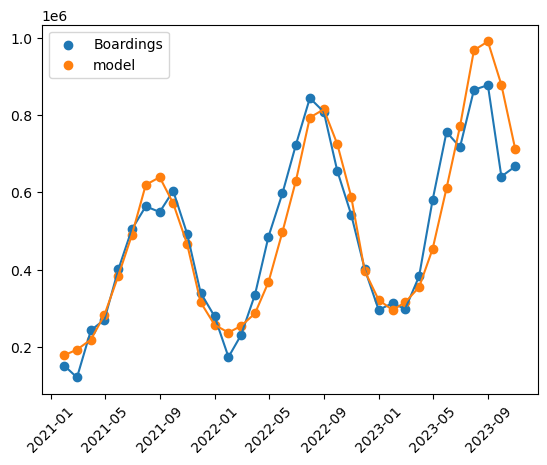

In [211]:
fig, ax = plt.subplots()

ax.scatter(model.index,model.Boardings,label = 'Boardings')
ax.plot(model.index,model.Boardings)


ax.scatter(model.index,model.ST,label = 'model')
ax.plot(model.index,model.ST)




ax.tick_params(axis='x', labelrotation=45)
ax.legend()

plt.show()

In [212]:
model_concat_predictions = pd.concat([model.ST,predictions.ST])

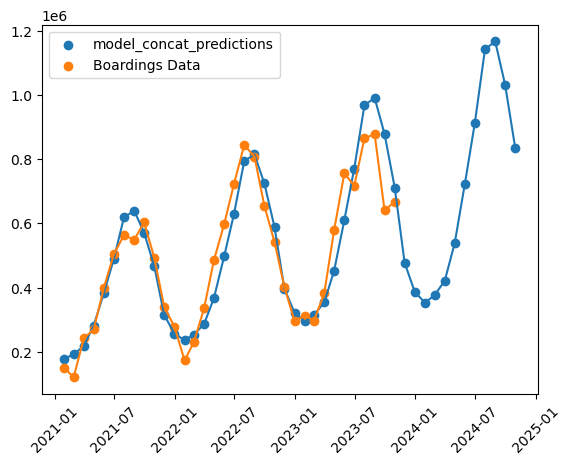

In [213]:
#Viewing our model with its predicitons.
fig, ax = plt.subplots()




ax.scatter(model_concat_predictions.index,model_concat_predictions,label = 'model_concat_predictions')
ax.plot(model_concat_predictions.index,model_concat_predictions)

ax.scatter(model.index,model.Boardings,label = 'Boardings Data')
ax.plot(model.index,model.Boardings)


ax.tick_params(axis='x', labelrotation=45)
ax.legend()

plt.show()

=== Below is extra code to compute other things and create pictures===

In [214]:
model

,X,Boardings,S,T,ST
Date,,,,,
2021-01-31,0,150695.0,0.533923,333721.392511,178181.373104
2021-02-28,1,120252.0,0.561283,342833.809609,192426.671459
2021-03-31,2,242713.0,0.620858,351946.226706,218508.736387
2021-04-30,3,269933.0,0.781502,361058.643804,282167.944551
2021-05-31,4,400295.0,1.037201,370171.060901,383941.905219
2021-06-30,5,504102.0,1.289639,379283.477999,489138.769024
2021-07-31,6,563801.0,1.595196,388395.895096,619567.621537
2021-08-31,7,549101.0,1.608437,397508.312193,639367.142564
2021-09-30,8,603836.0,1.405580,406620.729291,571537.852939


predictions = pd.Dat

In [215]:
boardings_per_month

,Boardings,Month,After_2021,MA12,SI,S,Deseasoned,X
Date,,,,,,,,
2017-07-31,470422.0,7,0,NaN,NaN,1.595196,294899.164210,0
2017-08-31,484719.0,8,0,NaN,NaN,1.608437,301360.233817,0
2017-09-30,459213.0,9,0,NaN,NaN,1.405580,326707.188334,0
2017-10-31,397407.0,10,0,NaN,NaN,1.121067,354489.845216,0
2017-11-30,244938.0,11,0,NaN,NaN,0.742177,330026.210279,0
...,...,...,...,...,...,...,...,...
2023-06-30,717197.0,6,1,NaN,NaN,1.289639,556122.290435,29
2023-07-31,865855.0,7,1,NaN,NaN,1.595196,542789.061368,30
2023-08-31,878015.0,8,1,NaN,NaN,1.608437,545880.821043,31


In [216]:
S

,S
Month,
1,0.533923
2,0.561283
3,0.620858
4,0.781502
5,1.037201
6,1.289639
7,1.595196
8,1.608437
9,1.405580


In [217]:
data.head()

,Route,Direction,Stop,Boardings,TypeDay
Date,,,,,
2021-07-01,RW,NB,Rockaway,20.0,Weekday
2021-07-01,RW,NB,Sunset Park/BAT,3.0,Weekday
2021-07-01,SV,SB,East 34th Street,1.0,Weekday
2021-07-01,SV,SB,East 90th St,0.0,Weekday
2021-07-01,SV,SB,Soundview,32.0,Weekday


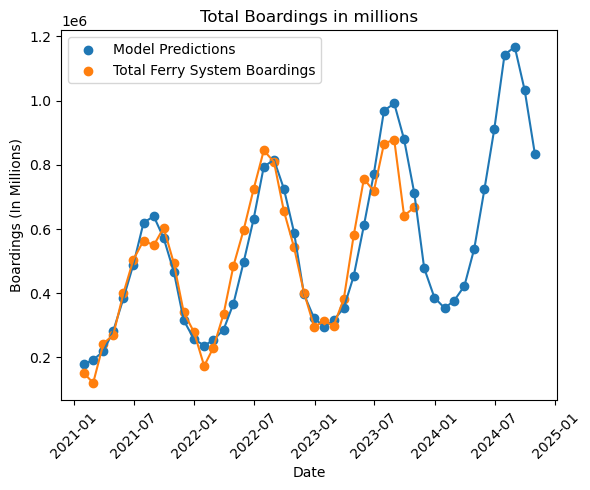

In [218]:
#Viewing our model with its predicitons.
fig, ax = plt.subplots()




ax.scatter(model_concat_predictions.index,model_concat_predictions,label = 'Model Predictions')
ax.plot(model_concat_predictions.index,model_concat_predictions)

ax.scatter(model.index,model.Boardings,label = 'Total Ferry System Boardings')
ax.plot(model.index,model.Boardings)


ax.tick_params(axis='x', labelrotation=45)
ax.legend()
ax.set_title('Total Boardings And Predictions')
ax.set_xlabel('Date')
ax.set_title('Total Boardings in millions')
ax.set_ylabel('Boardings (In Millions)')

plt.show()

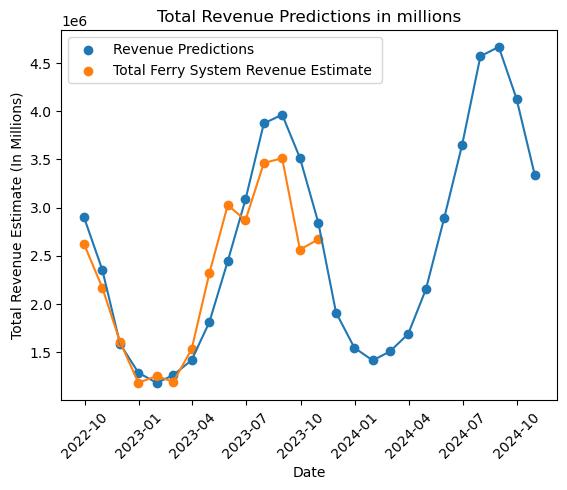

In [219]:
#Viewing our model with its predicitons.
fig, ax = plt.subplots()




ax.scatter(model_concat_predictions.index[model_concat_predictions.index > '2022-9-12'],4*model_concat_predictions[model_concat_predictions.index > '2022-9-12'],label = 'Revenue Predictions')
ax.plot(model_concat_predictions.index[model_concat_predictions.index > '2022-9-12'],4*model_concat_predictions[model_concat_predictions.index > '2022-9-12'])

ax.scatter(model.index[model.index > '2022-9-12'],4*model.Boardings[model.index > '2022-9-12'],label = 'Total Ferry System Revenue Estimate ')
ax.plot(model.index[model.index > '2022-9-12'],4*model.Boardings[model.index > '2022-9-12'])


ax.tick_params(axis='x', labelrotation=45)
ax.legend()
ax.set_title('Total Revenue estimate And Total Revenue Predictions')
ax.set_xlabel('Date')
ax.set_title('Total Revenue Predictions in millions')
ax.set_ylabel('Total Revenue Estimate (In Millions)')

plt.show()

Suppose we want to predict the revenue for the next 12 months from ticket sales for the NYC Ferry ferry system.

Below is for generating the right format for our predictions dataframe.

In [220]:
view_predictions = predictions.copy()

In [221]:
view_predictions.rename(columns={'X': 'Coded_Time'},inplace = True) 

In [222]:
view_predictions['Boardings_Predictions'] = view_predictions['ST']

In [223]:
view_predictions['Boardings_Predictions'].round()

2023-11-30     477624.0
2023-12-31     386139.0
2024-01-31     353333.0
2024-02-29     376554.0
2024-03-31     422179.0
2024-04-30     538537.0
2024-05-31     724193.0
2024-06-30     912201.0
2024-07-31    1142867.0
2024-08-31    1167010.0
2024-09-30    1032634.0
2024-10-31     833828.0
Freq: M, Name: Boardings_Predictions, dtype: float64

In [224]:
view_predictions.columns

Index(['Coded_Time', 'Month', 'S', 'T', 'ST', 'Boardings_Predictions'], dtype='object')

In [225]:
view_predictions.index.name = 'Date'

In [226]:
view_predictions.index.name

'Date'

In [227]:
view_predictions.index = view_predictions.index.date

In [228]:
view_predictions

,Coded_Time,Month,S,T,ST,Boardings_Predictions
2023-11-30,34,11,0.742177,643543.573825,4.776235e+05,4.776235e+05
2023-12-31,35,12,0.591643,652655.990922,3.861391e+05,3.861391e+05
2024-01-31,36,1,0.533923,661768.408020,3.533331e+05,3.533331e+05
2024-02-29,37,2,0.561283,670880.825117,3.765538e+05,3.765538e+05
2024-03-31,38,3,0.620858,679993.242214,4.221794e+05,4.221794e+05
2024-04-30,39,4,0.781502,689105.659312,5.385372e+05,5.385372e+05
2024-05-31,40,5,1.037201,698218.076409,7.241927e+05,7.241927e+05
2024-06-30,41,6,1.289639,707330.493507,9.122010e+05,9.122010e+05
2024-07-31,42,7,1.595196,716442.910604,1.142867e+06,1.142867e+06
2024-08-31,43,8,1.608437,725555.327702,1.167010e+06,1.167010e+06


In [229]:
def styled_df(df):
    s = (
        
        df.style.hide_columns(['Coded_Time', 'Month', 'S', 'T', 'ST'])
        .format({'Boardings_Predictions': '{:,.0f}'} )
    
    )
    return s
    

In [230]:
styled_df(view_predictions)

,Boardings_Predictions
2023-11-30,"477,624"
2023-12-31,"386,139"
2024-01-31,"353,333"
2024-02-29,"376,554"
2024-03-31,"422,179"
2024-04-30,"538,537"
2024-05-31,"724,193"
2024-06-30,"912,201"
2024-07-31,"1,142,867"
2024-08-31,"1,167,010"


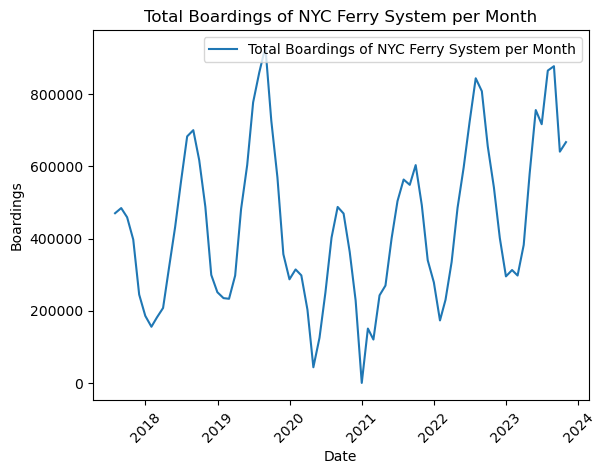

In [231]:
fig, ax = plt.subplots()

ax.plot(boardings_per_month.Boardings,label ='Total Boardings of NYC Ferry System per Month' )




ax.tick_params(axis='x', labelrotation=45)
ax.legend()
ax.set_xlabel('Date')
ax.set_title('Total Boardings of NYC Ferry System per Month')
ax.set_ylabel('Boardings')

# plt.savefig('TotalBoardingsGraph.png')

plt.show()

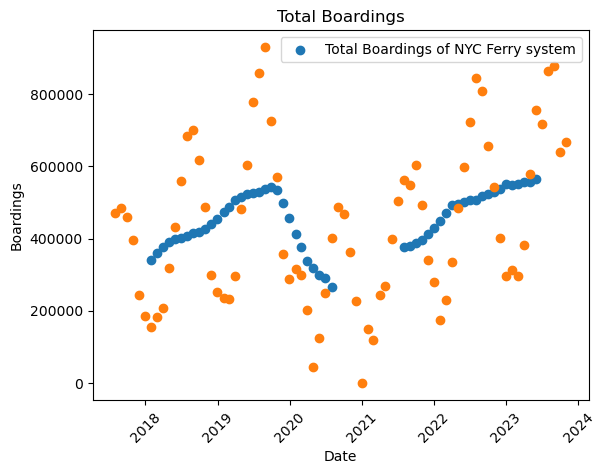

In [232]:
fig, ax = plt.subplots()

ax.scatter(boardings_per_month.index,boardings_per_month.MA12,label ='Total Boardings of NYC Ferry system' )



ax.tick_params(axis='x', labelrotation=45)
ax.legend()
ax.set_title('Total Boardings of NYC Ferry system')
ax.set_xlabel('Date')
ax.set_title('Total Boardings')
ax.set_ylabel('Boardings')


ax.scatter(boardings_per_month.index,boardings_per_month.Boardings,label ='Total Boardings of NYC Ferry system' )

plt.show()

In [233]:
boardings_per_month

,Boardings,Month,After_2021,MA12,SI,S,Deseasoned,X
Date,,,,,,,,
2017-07-31,470422.0,7,0,NaN,NaN,1.595196,294899.164210,0
2017-08-31,484719.0,8,0,NaN,NaN,1.608437,301360.233817,0
2017-09-30,459213.0,9,0,NaN,NaN,1.405580,326707.188334,0
2017-10-31,397407.0,10,0,NaN,NaN,1.121067,354489.845216,0
2017-11-30,244938.0,11,0,NaN,NaN,0.742177,330026.210279,0
...,...,...,...,...,...,...,...,...
2023-06-30,717197.0,6,1,NaN,NaN,1.289639,556122.290435,29
2023-07-31,865855.0,7,1,NaN,NaN,1.595196,542789.061368,30
2023-08-31,878015.0,8,1,NaN,NaN,1.608437,545880.821043,31
